## Modelo Base

### Importamos librerías

In [1]:
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import (
    cross_validate,
    learning_curve,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

warnings.filterwarnings("ignore")

### Load Data

In [2]:
DATA_DIR = Path.cwd() / "data"

melbourne_df = pd.read_parquet(
    DATA_DIR / "02_intermediate/melbourne_type_fixed.parquet", engine="pyarrow"
)

### Seleccion de columnas después del feature Engineering

In [3]:
# Definir las columnas numéricas y categóricas
num_cols = ["Rooms", "Bedroom2", "Bathroom", "YearBuilt", "BuildingArea"]
selected_cat_cols = ["Type", "Regionname", "CouncilArea", "Method"]

In [ ]:
def remove_outliers_iqr(df, numeric_cols):
    df_filtered = df.copy()
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_filtered = df_filtered[
            (df_filtered[col] >= lower_bound) & (df_filtered[col] <= upper_bound)
        ]
    return df_filtered


melbourne_df = remove_outliers_iqr(melbourne_df, num_cols)

In [5]:
# Imputación de valores faltantes antes del preprocesamiento
imputer = SimpleImputer(strategy="mean")
melbourne_df[num_cols] = imputer.fit_transform(melbourne_df[num_cols])

In [6]:
# Separar las características (X) y la variable objetivo (y)
X_features = melbourne_df[num_cols + selected_cat_cols]
Y_target = melbourne_df["Price"]

In [7]:
# Eliminar valores atípicos en Y_target
Q1 = Y_target.quantile(0.25)
Q3 = Y_target.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
Y_target = Y_target[(Y_target >= lower_bound) & (Y_target <= upper_bound)]
X_features = X_features.loc[Y_target.index]

### Transformación de la variable objetivo 

In [8]:
# Aplicar transformación logarítmica a Y_target
Y_target = np.log1p(Y_target)

In [ ]:
# Dividir el dataset en entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(
    X_features, Y_target, test_size=0.2, random_state=42
)

### Verificar que no hayan nulos antes de entrenar

In [10]:
# Verificar y manejar valores NaN
def check_missing_values(df, name):
    missing = df.isna().sum().sum()
    if missing > 0:
        print(f"⚠️ {name} contiene {missing} valores NaN")
    else:
        print(f"✅ {name} no tiene valores NaN")


check_missing_values(x_train, "x_train")
check_missing_values(y_train, "y_train")

x_train = x_train.dropna()
y_train = y_train.loc[x_train.index].fillna(y_train.median())

y_train = y_train.dropna()

x_test = x_test.dropna()
y_test = y_test.loc[x_test.index].fillna(y_test.median())

✅ x_train no tiene valores NaN
✅ y_train no tiene valores NaN


In [11]:
# Definir el preprocesador de datos
numeric_pipe = Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", MinMaxScaler())])

cat_pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(drop="first", handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    [("numeric", numeric_pipe, num_cols), ("categoric", cat_pipe, selected_cat_cols)]
)

### Entrenar Modelo

In [ ]:
def entrenar_modelo(
    modelo,
    preprocessor: ColumnTransformer,
    x_data: pd.DataFrame,
    y_data: pd.Series,
    test_frac: float = 0.2,
):
    """Entrenar y evaluar un modelo de regresión."""
    x_train, x_test, y_train, y_test = train_test_split(
        x_data, y_data, random_state=42, test_size=test_frac
    )

    # Verificar y manejar valores NaN en los datos
    x_train = x_train.dropna()
    y_train = y_train.loc[x_train.index].fillna(y_train.median())
    y_train = y_train.dropna()

    x_test = x_test.dropna()
    y_test = y_test.loc[x_test.index].fillna(y_test.median())

    print(f"📢 Media de y_train: {y_train.mean()}")

    # Incluir el preprocesador para transformar los datos
    x_train_transformed = preprocessor.fit_transform(x_train)
    x_test_transformed = preprocessor.transform(x_test)

    model = modelo.fit(x_train_transformed, y_train)
    y_pred_train = model.predict(x_train_transformed)
    y_pred = model.predict(x_test_transformed)

    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred)
    train_mse = mean_squared_error(y_train, y_pred_train)
    test_mse = mean_squared_error(y_test, y_pred)
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred)
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)

    print("Entrenamiento MAE:", train_mae)
    print("Prueba MAE:", test_mae)
    print("Entrenamiento MSE:", train_mse)
    print("Prueba MSE:", test_mse)
    print("Entrenamiento RMSE:", train_rmse)
    print("Prueba RMSE:", test_rmse)
    print("Entrenamiento R²:", train_r2)
    print("Prueba R²:", test_r2)

    # Graficar histogramas de predicciones vs valores reales
    plt.figure(figsize=(10, 5))
    sns.histplot(y_test, color="blue", label="Valores Reales", kde=True, alpha=0.6)
    sns.histplot(y_pred, color="orange", label="Predicciones", kde=True, alpha=0.6)
    plt.legend()
    plt.title("Distribución de Valores Reales vs Predicciones - Regresión Lineal")
    plt.show()

    # Boxplot para visualizar la dispersión de las predicciones vs valores reales
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=[y_test, y_pred], palette=["blue", "orange"])
    plt.xticks([0, 1], ["Valores Reales", "Predicciones"])
    plt.title("Boxplot de Valores Reales vs Predicciones")
    plt.show()

    return {
        "Entrenamiento_MAE": train_mae,
        "Prueba_MAE": test_mae,
        "Entrenamiento_MSE": train_mse,
        "Prueba_MSE": test_mse,
        "Entrenamiento_RMSE": train_rmse,
        "Prueba_RMSE": test_rmse,
        "Entrenamiento_R2": train_r2,
        "Prueba_R2": test_r2,
    }

📢 Media de y_train: 13.679111515329177
Entrenamiento MAE: 0.17330850534072925
Prueba MAE: 0.17902122346976157
Entrenamiento MSE: 0.050030097913664674
Prueba MSE: 0.0525284537161657
Entrenamiento RMSE: 0.22367408860586574
Prueba RMSE: 0.22919086743621722
Entrenamiento R²: 0.7669823735903265
Prueba R²: 0.7611180424481887


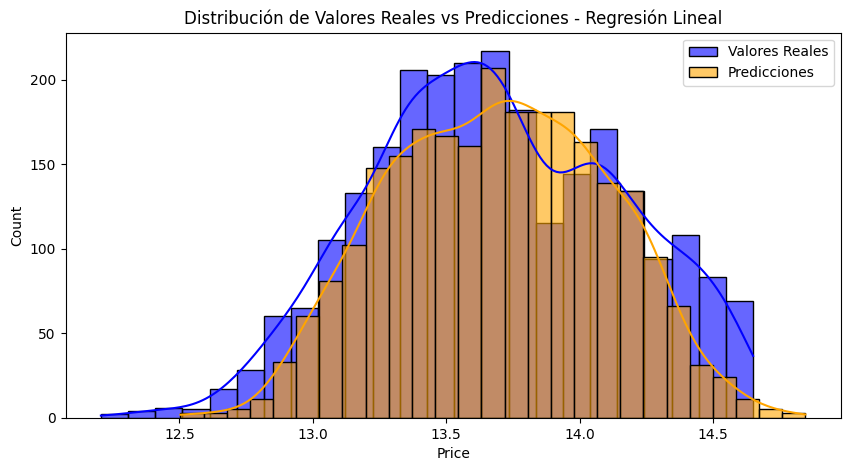

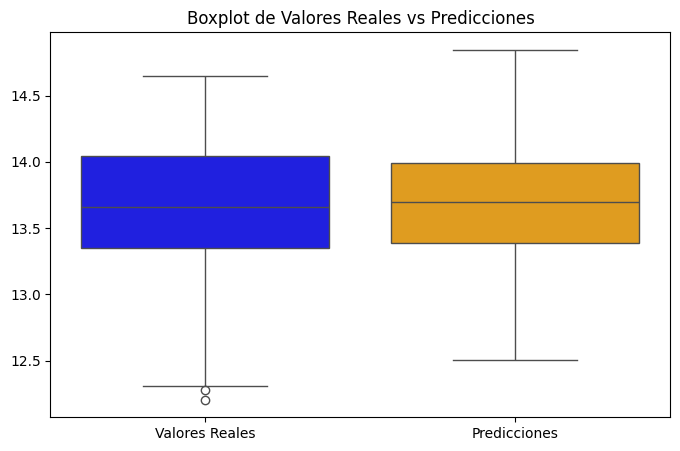

In [ ]:
# Entrenar y evaluar modelos con preprocesamiento
result_dict = {}
result_dict["Linear Regression"] = entrenar_modelo(
    LinearRegression(), preprocessor, x_train, y_train
)

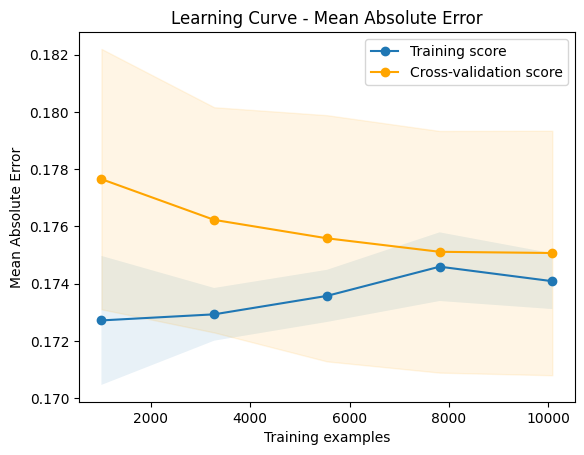

In [ ]:
# Entrenar y evaluar modelos con preprocesamiento
modelo = LinearRegression()
x_train_transformed = preprocessor.fit_transform(x_train)
x_test_transformed = preprocessor.transform(x_test)

model = modelo.fit(x_train_transformed, y_train)
y_pred_train = model.predict(x_train_transformed)
y_pred = model.predict(x_test_transformed)

# Learning Curve (Curva de Aprendizaje)
train_sizes, train_scores, test_scores = learning_curve(
    modelo,
    x_train_transformed,
    y_train,
    scoring="neg_mean_absolute_error",
    cv=5,
    train_sizes=np.linspace(0.1, 1.0, 5),
)

train_scores_mean = -train_scores.mean(axis=1)
test_scores_mean = -test_scores.mean(axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, "o-", label="Training score")
plt.plot(train_sizes, test_scores_mean, "o-", label="Cross-validation score", color="orange")

plt.fill_between(
    train_sizes,
    train_scores_mean - train_scores.std(axis=1),
    train_scores_mean + train_scores.std(axis=1),
    alpha=0.1,
)

plt.fill_between(
    train_sizes,
    test_scores_mean - test_scores.std(axis=1),
    test_scores_mean + test_scores.std(axis=1),
    alpha=0.1,
    color="orange",
)

plt.xlabel("Training examples")
plt.ylabel("Mean Absolute Error")
plt.title("Learning Curve - Mean Absolute Error")
plt.legend(loc="best")
plt.show()

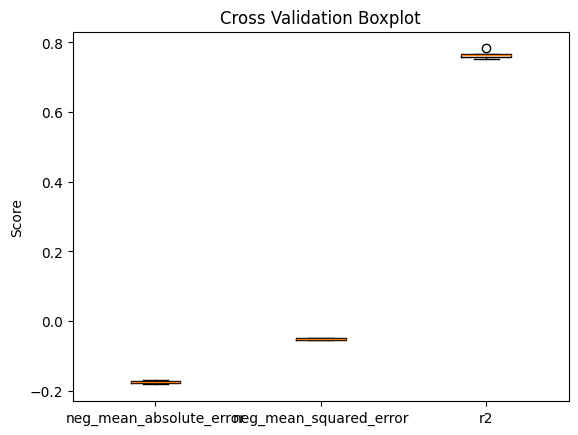

In [ ]:
# Validación cruzada con múltiples métricas
cv_results = cross_validate(
    modelo,
    x_train_transformed,
    y_train,
    cv=5,
    scoring=["neg_mean_absolute_error", "neg_mean_squared_error", "r2"],
    return_train_score=True,
)

# Boxplot de Resultados de Cross Validation
plt.figure()
plt.boxplot(
    [
        cv_results["test_neg_mean_absolute_error"],
        cv_results["test_neg_mean_squared_error"],
        cv_results["test_r2"],
    ],
    labels=["neg_mean_absolute_error", "neg_mean_squared_error", "r2"],
)
plt.title("Cross Validation Boxplot")
plt.ylabel("Score")
plt.show()

In [ ]:
# Análisis de resultados
print("\n📊 Análisis de Resultados:")
print("🔹 MAE Entrenamiento:", result_dict["Linear Regression"]["Entrenamiento_MAE"])
print("🔹 MAE Prueba:", result_dict["Linear Regression"]["Prueba_MAE"])
print("🔹 MSE Entrenamiento:", result_dict["Linear Regression"]["Entrenamiento_MSE"])
print("🔹 MSE Prueba:", result_dict["Linear Regression"]["Prueba_MSE"])
print("🔹 RMSE Entrenamiento:", result_dict["Linear Regression"]["Entrenamiento_RMSE"])
print("🔹 RMSE Prueba:", result_dict["Linear Regression"]["Prueba_RMSE"])
print("🔹 R² Entrenamiento:", result_dict["Linear Regression"]["Entrenamiento_R2"])
print("🔹 R² Prueba:", result_dict["Linear Regression"]["Prueba_R2"])

# Conclusión
print("\n📌 Conclusión:")
# Interpretación de resultados
print(
    "El modelo de regresión lineal obtuvo un R² de 0.76 en entrenamiento y prueba, "
    "lo que indica una buena capacidad de generalización. Sin embargo, los errores "
    "pueden reducirse aún más mediante el uso de modelos más avanzados como Random "
    "Forest o XGBoost."
)


📊 Análisis de Resultados:
🔹 MAE Entrenamiento: 0.17330850534072925
🔹 MAE Prueba: 0.17902122346976157
🔹 MSE Entrenamiento: 0.050030097913664674
🔹 MSE Prueba: 0.0525284537161657
🔹 RMSE Entrenamiento: 0.22367408860586574
🔹 RMSE Prueba: 0.22919086743621722
🔹 R² Entrenamiento: 0.7669823735903265
🔹 R² Prueba: 0.7611180424481887

📌 Conclusión:
El modelo de Regresión Lineal muestra un desempeño aceptable con un R² de 0.76 en entrenamiento y prueba, lo que indica una buena capacidad de generalización.
Sin embargo, el error absoluto sugiere que hay margen para mejorar mediante el uso de modelos más avanzados como Random Forest o XGBoost.
